# Importing Libraries

The FitnessGram™ Pacer Test is a multistage aerobic capacity test that progressively gets more difficult as it continues. The 20 meter pacer test will begin in 30 seconds. Line up at the start. The running speed starts slowly, but gets faster each minute after you hear this signal. <i>beep</i> A single lap should be completed each time you hear this sound. <i>ding</i> Remember to run in a straight line, and run as long as possible. The second time you fail to complete a lap before the sound, your test is over. The test will begin on the word start. <b>On your mark, get ready, start.</b>

In [154]:
import ase.io # for reading *.xyz
import pandas as pd # for dataframes?
import matplotlib.pyplot as plt # for plotting error distribution

# Setting Variables and Functions

In [155]:
DATASET_LOCATION = "./data_structures_errors_head.xyz"

In [156]:
def sort_df(df, sort_method): # to sort df by certain column and display the line plot
    df_sorted = df.sort_values(by=[sort_method])

    plt.figure(figsize=(10,5))
    plt.xlabel(sort_method.capitalize())
    plt.ylabel("Energy (Error)")
    plt.ylim(-1.1*df["energy (error)"].abs().max(), 1.1*df["energy (error)"].abs().max())
    plt.plot(df_sorted[sort_method], df_sorted['energy (error)'])
    plt.scatter(df_sorted[sort_method], df_sorted['energy (error)'])
    plt.axhline(y=0, color='r', linestyle='--')

    plt.show()

# Reading and Importing Dataset

In [157]:
dataset_list = list(ase.io.iread(filename=DATASET_LOCATION, format="extxyz")) # reading *.xyz file as a generator, then converting into list
df = pd.DataFrame(dataset_list)

df["number of atoms"] = [dataset_list[i].get_global_number_of_atoms() for i in range(len(dataset_list))]
df["chemical formula"] = [dataset_list[i].get_chemical_formula() for i in range(len(dataset_list))]
df["Lattice (unit cell with three vectors)"] = [dataset_list[i].get_cell()[:] for i in range(len(dataset_list))]
df["volume of unit cell (derived from Lattice)"] = [dataset_list[i].get_cell().volume for i in range(len(dataset_list))]
df["energy (error)"] = [dataset_list[i].info["energy"] for i in range(len(dataset_list))]
# Properties part not impt; pbc is "T T T" for all

display(df.head())

# possible way of extracting data out from Atom object
# print(df[0][0])
# print(df[0][0].symbol)
# print(df[0][0].position)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,number of atoms,chemical formula,Lattice (unit cell with three vectors),volume of unit cell (derived from Lattice),energy (error)
0,"Atom('Al', [7.02555561, 0.0, 12.73458958], ind...","Atom('Al', [6.96548843, 10.95924854, 17.195571...","Atom('Al', [1.07926452, 5.47962427, 14.9782791...","Atom('Al', [-1.92391455, 13.69906044, 18.33061...","Atom('Al', [4.02237654, 8.21943665, 16.0869255...","Atom('Al', [9.96866703, 2.73981214, 13.8432350...","Atom('Al', [3.7433207, 12.48701859, 14.1275119...","Atom('Al', [9.68961143, 7.00739479, 11.8838224...","Atom('Al', [0.84525955, 1.52777028, 17.5194454...","Atom('Al', [-2.17380166, 12.64488316, 13.75287...",...,"Atom('Rh', [-1.59269428, 13.04013824, 11.23341...","Atom('Rh', [1.39546812, 7.56051397, 16.8426418...","Atom('Rh', [7.3417592, 2.0808897, 14.59895134]...","Atom('N', [10.07435799, 0.67007822, 18.0502204...","Atom('H', [9.81685925, 1.29785168, 18.81179428...",86,HAl60NRh24,"[[11.832514762878418, 0.0, -0.0263979993760585...",6104.848367,0.325074
1,"Atom('Zr', [5.31270552, 11.38425636, 12.790607...","Atom('Zr', [5.31270552, 4.67047501, 12.7906074...","Atom('Zr', [2.12508202, 4.67047501, 10.9502325...","Atom('Zr', [8.50032902, 11.38425636, 10.950232...","Atom('Zr', [7.43778753, 8.75708675, 12.7906074...","Atom('Zr', [1.06254113, 2.04330564, 12.7906074...","Atom('Zr', [4.25016451, 2.04330564, 10.9502315...","Atom('Zr', [4.25016451, 8.75708675, 10.9502315...","Atom('Zr', [5.31270552, 11.38425636, 16.471357...","Atom('Zr', [5.31270552, 4.67047501, 16.4713573...",...,"Atom('C', [11.13760567, 7.08530903, 18.8511924...","Atom('H', [11.48986053, 6.99335003, 19.8573532...","Atom('O', [11.08401871, 4.55318403, 18.5853538...","Atom('O', [10.92179871, 8.37140369, 18.2892417...",None,85,C2HN32O2Se16Zr32,"[[12.750493049621582, 0.0, 0.0], [3.1876232624...",5041.392243,-1.486445
2,"Atom('Ag', [1.99755764, 0.0, 12.556077], index=0)","Atom('Ag', [1.99755764, 0.0, 16.55119133], ind...","Atom('Ag', [1.99755764, 0.0, 20.54630661], ind...","Atom('Ag', [5.99267292, 0.0, 12.556077], index=3)","Atom('Ag', [5.99267292, 0.0, 16.55119133], ind...","Atom('Ag', [5.99267292, 0.0, 20.54630661], ind...","Atom('Ag', [9.9877882, 0.0, 12.556077], index=6)","Atom('Ag', [9.9877882, 0.0, 16.55119133], inde...","Atom('Ag', [9.9877882, 0.0, 20.54630661], inde...","Atom('P', [0.0, 3.52585888, 10.55851936], inde...",...,None,None,None,None,None,66,H2Ag9OP9Pd45,"[[11.985345840454102, 0.0, 0.0], [0.0, 7.05171...",3038.906189,0.198341
3,"Atom('Hf', [9.38242626, 12.50322628, 14.585413...","Atom('Hf', [6.35710812, 3.12580657, 18.5775795...","Atom('Hf', [7.86976767, 7.81451654, 21.8971786...","Atom('Hf', [6.96020222, 13.28467846, 19.901096...","Atom('Hf', [3.93488359, 3.90725827, 23.8932628...","Atom('Hf', [5.44754267, 8.59596825, 16.5814971...","Atom('Hf', [6.20387268, 10.94032288, 18.241296...","Atom('Hf', [3.17855406, 1.56290329, 22.2334613...","Atom('Hf', [4.69121313, 6.25161314, 14.9216957...","Atom('Hf', [5.60077858, 0.7814517, 16.91777992...",...,None,None,None,None,None,62,C2H5Hf30OSn24,"[[8.023002624511719, 0.0, -3.6558828353881836]...",4799.108881,-5.876447
4,"Atom('Tc', [5.52350187, 3.18899536, 15.7963838...","Atom('Tc', [8.28525257, 7.9724884, 20.15400696...","Atom('Tc', [2.76175094, 1.59449768, 17.9751968...","Atom('Tc', [5.52350187, 6.37799072, 17.9751968...","Atom('Tc', [5.52350187, 3.18899536, 20.1540069...","Atom('Tc', [8.28525257, 7.9724884, 24.51163101...","Atom('Tc', [2.76175094, 1.59449768, 22.3328189...","Atom('Tc', [5.52350187, 6.37799072, 22.3328189...","Atom('Tc', [11.04700375, 3.18899536, 15.796383...","Atom('Tc', [13.80875492, 7.9724884, 20.1540069...",...,None,None,None,None,None,67,CH2Os48Tc16,"[[11.047003746032715, 0.0, 0.0], [5.5235018730...",3684.336555,-2.103216


# Exploratory Analysis

,number of atoms,volume of unit cell (derived from Lattice),energy (error)
count,5.000000,5.000000,5.000000
mean,73.200000,4533.718447,-1.788539
std,11.388591,1199.221339,2.515767
min,62.000000,3038.906189,-5.876447
25%,66.000000,3684.336555,-2.103216
50%,67.000000,4799.108881,-1.486445
75%,85.000000,5041.392243,0.198341
max,86.000000,6104.848367,0.325074


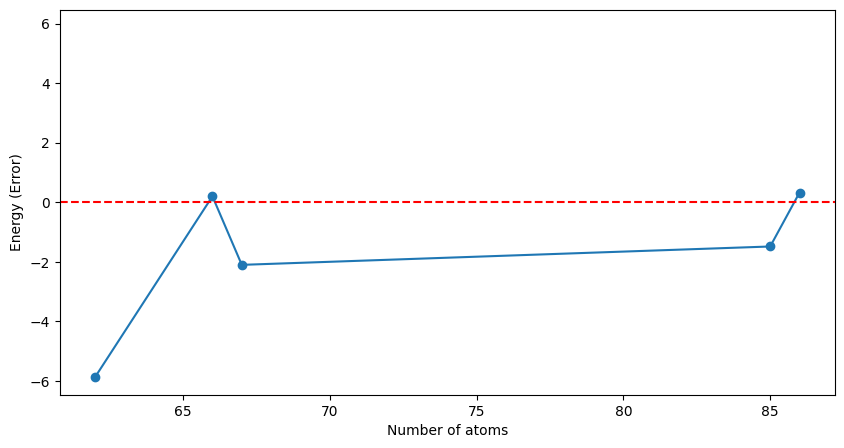

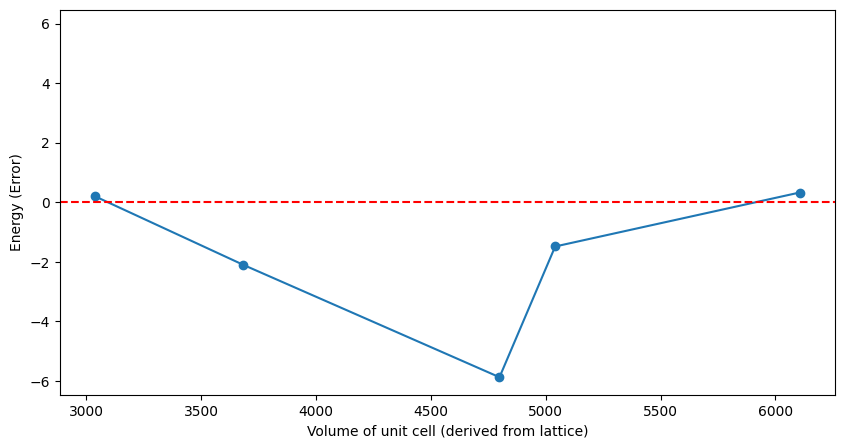

In [158]:
display(df.describe())
sort_df(df, "number of atoms")
sort_df(df, "volume of unit cell (derived from Lattice)")
